In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
# pd.set_option('display.max_rows', 1000)  # or 1000
# pd.set_option('display.max_columns', 1000)  # or 1000

from itertools import combinations
from itertools import permutations

from sklearn.preprocessing import OneHotEncoder

In [2]:
def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series


    # Create train/test splits.
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=50000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    print(f'Lasso alpha used: {lasso.alpha_}')

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 

    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    
    return X_train, X_test, y_train, y_test, lasso_best

In [3]:
main_data = pd.read_csv('main_data.csv')
main_data.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
main_data

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,kitchen_qual,garage_finish,fireplace_qu,total_bsmt_sf_class,neighborhood_class,gr_liv_area_class,sale_price,garage_area,bsmtfin_sf1,tot_rms_abv_grd
0,109,69.0552,13517,6,34,5,4,3,5,725.0,...,4,2,0,0,0,0,130500.0,475.0,533.0,6
1,544,43.0000,11492,7,13,12,4,4,5,913.0,...,4,2,3,0,0,0,220000.0,559.0,637.0,8
2,153,68.0000,7922,5,57,3,3,3,3,1057.0,...,4,1,0,0,0,0,109000.0,246.0,731.0,5
3,318,73.0000,9802,5,4,3,3,4,4,384.0,...,3,3,0,0,0,0,174000.0,400.0,0.0,7
4,255,82.0000,14235,6,110,17,3,2,3,676.0,...,3,1,0,0,0,0,138500.0,484.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,1662,80.0000,8000,6,33,33,3,3,3,1084.0,...,3,1,3,0,0,0,NaN,488.0,931.0,8
2923,1234,90.0000,14670,6,42,9,4,3,5,1104.0,...,4,2,4,0,0,0,NaN,480.0,575.0,9
2924,1373,55.0000,8250,5,40,40,3,3,5,952.0,...,3,1,3,0,0,0,NaN,322.0,250.0,5
2925,1672,60.0000,9000,4,36,36,3,3,3,864.0,...,3,1,0,0,0,0,NaN,528.0,616.0,5


### Declare X and y variables 

In [5]:
# split test data (Kaggle)
# cross check -->> OK

kaggle_test_final = main_data[2049:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [6]:
# split train data (Kaggle)

kaggle_train_final = main_data[:2049]
kaggle_train_final['sale_price'].tail(10)

2039    412500.0
2040     83000.0
2041    128000.0
2042    182000.0
2043    394617.0
2044    298751.0
2045     82500.0
2046    177000.0
2047    144000.0
2048    189000.0
Name: sale_price, dtype: float64

## Pre - processing

**Apply Standard Scaler**

In [7]:
# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']


# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Modelling

**Lasso Regression**

In [8]:
# initiate 
lasso = LassoCV(
    cv=5,
    max_iter=50000,
    n_alphas=200,
)

# Fit model using best ridge alpha!
lasso.fit(X_train, y_train);


lasso.alpha_

263.64738631554894

In [9]:
lasso_best = Lasso(alpha = lasso.alpha_)

In [10]:
# fit lasso best 

lasso_best.fit(X_train,y_train)

Lasso(alpha=263.64738631554894)

In [11]:
# cross val mse
cross_score = - cross_val_score(
    lasso_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    lasso_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')

MSE for train: 756509927.414051
MSE for test: 545632240.4113383
Underfited by: 210877687.00271273
RMSE: 23358.772236813697


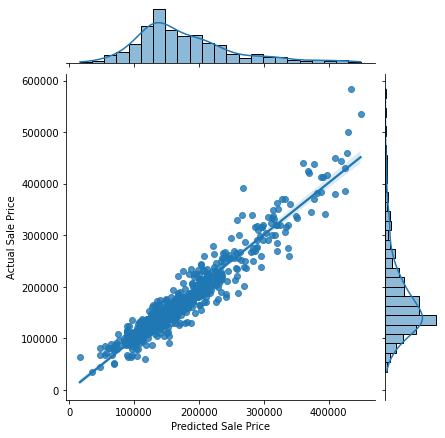

In [12]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

<AxesSubplot:>

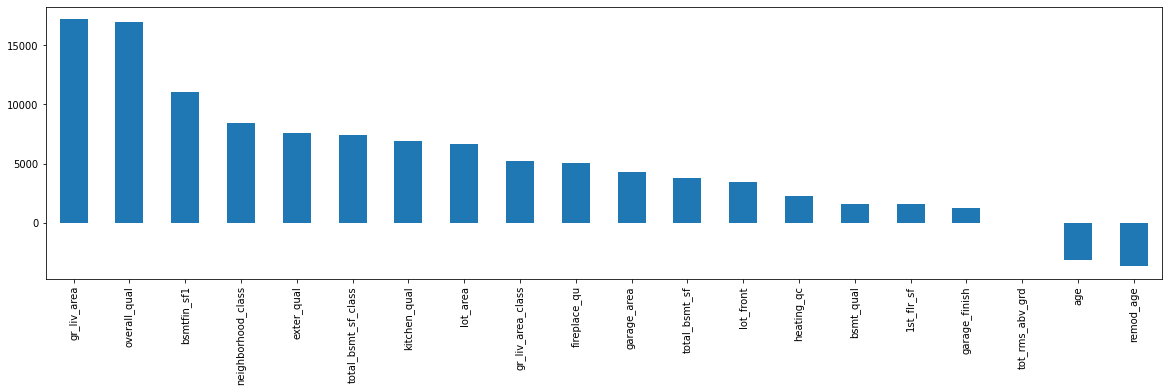

In [13]:
# hwo to plot the series 
plt.figure(figsize=(20,5))

col = kaggle_train_final.columns.drop(['sale_price', 'id'])
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

**Add interaction terms**

<AxesSubplot:xlabel='interaction_1', ylabel='sale_price'>

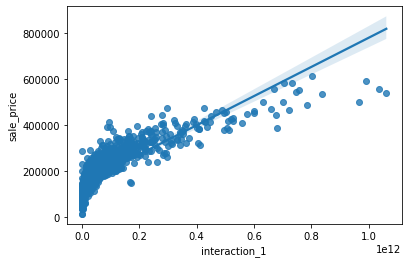

In [14]:
kaggle_train_final['interaction_1'] = kaggle_train_final['lot_area']**0.5 *\
kaggle_train_final['overall_qual']*kaggle_train_final['kitchen_qual']*\
kaggle_train_final['exter_qual']* kaggle_train_final['bsmt_qual']* kaggle_train_final['heating_qc']*\
kaggle_train_final['total_bsmt_sf']**0.5 * kaggle_train_final['1st_flr_sf']**0.5 *kaggle_train_final['gr_liv_area']**0.5\
* kaggle_train_final['tot_rms_abv_grd']


sns.regplot(
    x = 'interaction_1',
    y = 'sale_price',
    data = kaggle_train_final
)

In [15]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best= lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

Lasso alpha used: 139.19439703247073
MSE for train: 529102866.9261438
MSE for test: 442509427.06724864
Underfited by: 86593439.85889518
RMSE: 21035.908039997907


In [16]:
# Change in RMSE 

RMSE_before_interaction_term = 23358.772236813697
RMSE_after_interaction_term= 21035.908039997907

Difference = RMSE_after_interaction_term - RMSE_before_interaction_term
percent_dif = round(Difference/RMSE_before_interaction_term * 100, 2)
print(f'Current RMSE: {RMSE_after_interaction_term}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 21035.908039997907
Difference in RMSE: -2322.86419681579
Percentage diff: -9.94%


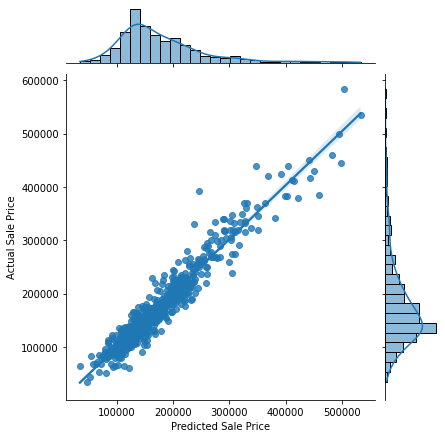

In [17]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

**Need to consider other nominal categories for better fit**

In [18]:
main_data_other_col = pd.read_csv('Main_with_other_df.csv')
main_data_other_col.drop(columns = 'Unnamed: 0', inplace = True)
main_data_other_col.drop(columns = ['sale_price_classified'], inplace = True)
main_data_other_col.drop(index = [960,1885], inplace = True)

In [19]:
main_data_other_col['interaction_1'] = main_data_other_col['lot_area']**0.5 *\
main_data_other_col['overall_qual']*main_data_other_col['kitchen_qual']*\
main_data_other_col['exter_qual']* main_data_other_col['bsmt_qual']* main_data_other_col['heating_qc']*\
main_data_other_col['total_bsmt_sf']**0.5 * main_data_other_col['1st_flr_sf']**0.5 *main_data_other_col['gr_liv_area']**0.5\
* main_data_other_col['tot_rms_abv_grd']

In [20]:
indexer = main_data_other_col.shape[0] - len(main_data_other_col[pd.isnull(main_data_other_col['sale_price'])])
print(f'Indexer: {indexer}')

kaggle_test_final = main_data_other_col[indexer:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

Indexer: 2049


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [21]:
kaggle_train_final = main_data_other_col[:indexer]
kaggle_train_final['sale_price'].tail(10)

2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

In [22]:
# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
indices = X.index.values

# Create train/test splits.
X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
    X,
    y,
    indices,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

lr = LinearRegression()

lr.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    lr,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test_2 = mean_squared_error(
    y_test,
    lr.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test_2

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test_2}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test_2}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test_2**0.5}')

MSE for train: 3.193102209928571e+30
MSE for test: 8.001735500581817e+28
Underfited by: 3.1130848549227526e+30
RMSE: 282873390416663.56


**When fitted with many variables, linear regression model has too much variance**
- Need to do Lasso regression for regularization purpose 


In [23]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best= lasso_reg(
    X_df = kaggle_train_final.drop(columns = ['sale_price','id']),
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

Lasso alpha used: 598.1189788636289
MSE for train: 504979968.93019146
MSE for test: 378739333.3446132
Underfited by: 126240635.58557826
RMSE: 19461.226409057916


In [24]:
# Change in RMSE 

RMSE_before_col_added = 21307.243244336474
RMSE_after_col_added= 19737.081676235735

Difference = RMSE_after_col_added - RMSE_before_col_added
percent_dif = round(Difference/RMSE_before_col_added * 100, 2)
print(f'Current RMSE: {RMSE_after_col_added}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 19737.081676235735
Difference in RMSE: -1570.1615681007388
Percentage diff: -7.37%


<AxesSubplot:>

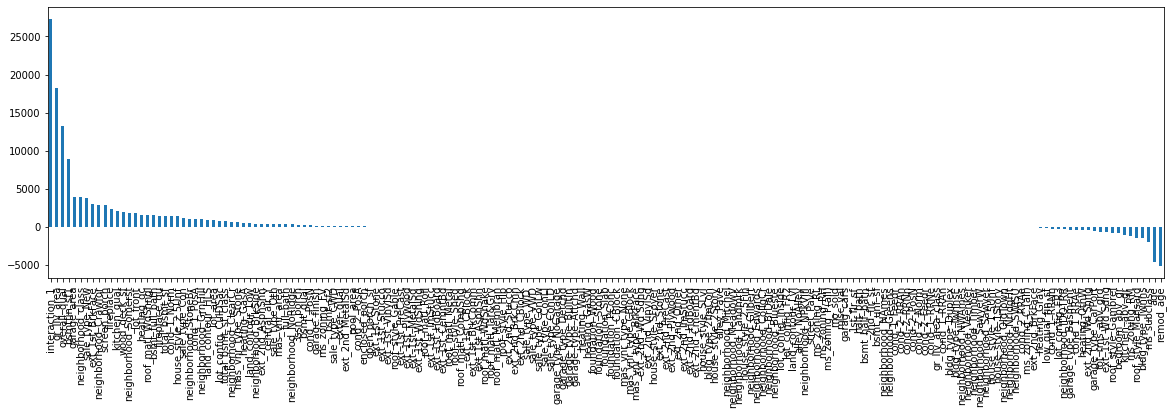

In [25]:
# hwo to plot the series 
plt.figure(figsize=(20,5))

col = kaggle_train_final.columns.drop(['sale_price', 'id'])
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

**Optimise model**

In [26]:
feature_set_model = SelectFromModel(lasso_best)
feature_set_model.fit(X_train,y_train)

SelectFromModel(estimator=Lasso(alpha=598.1189788636289))

In [27]:
feature_set_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
        True, False,  True, False, False, False,  True,  True, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True,  True,  True,  True,
       False, False,  True, False, False,  True, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False,

In [28]:
#refined model from 534 columns to 215 columns 

refined = list(kaggle_train_final.columns.drop(['sale_price','id'])[feature_set_model.get_support()])
len(refined)

79

In [29]:
# redo scale and lasso 
# reduced by hundred. 
X_train, X_test, y_train, y_test, lasso_best= lasso_reg(
    X_df = kaggle_train_final.loc[:,refined],
    y_series = kaggle_train_final['sale_price'],
    test_size = 0.3
)

Lasso alpha used: 165.5764772571939
MSE for train: 469439053.128354
MSE for test: 378121073.20707434
Underfited by: 91317979.92127967
RMSE: 19445.33551284406


Text(27.125, 0.5, 'Actual Sale Price')

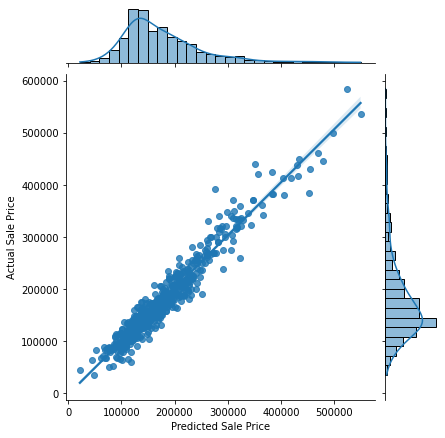

In [30]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax2 = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax2.ax_joint.set_xlabel('Predicted Sale Price')
ax2.ax_joint.set_ylabel('Actual Sale Price')

<AxesSubplot:>

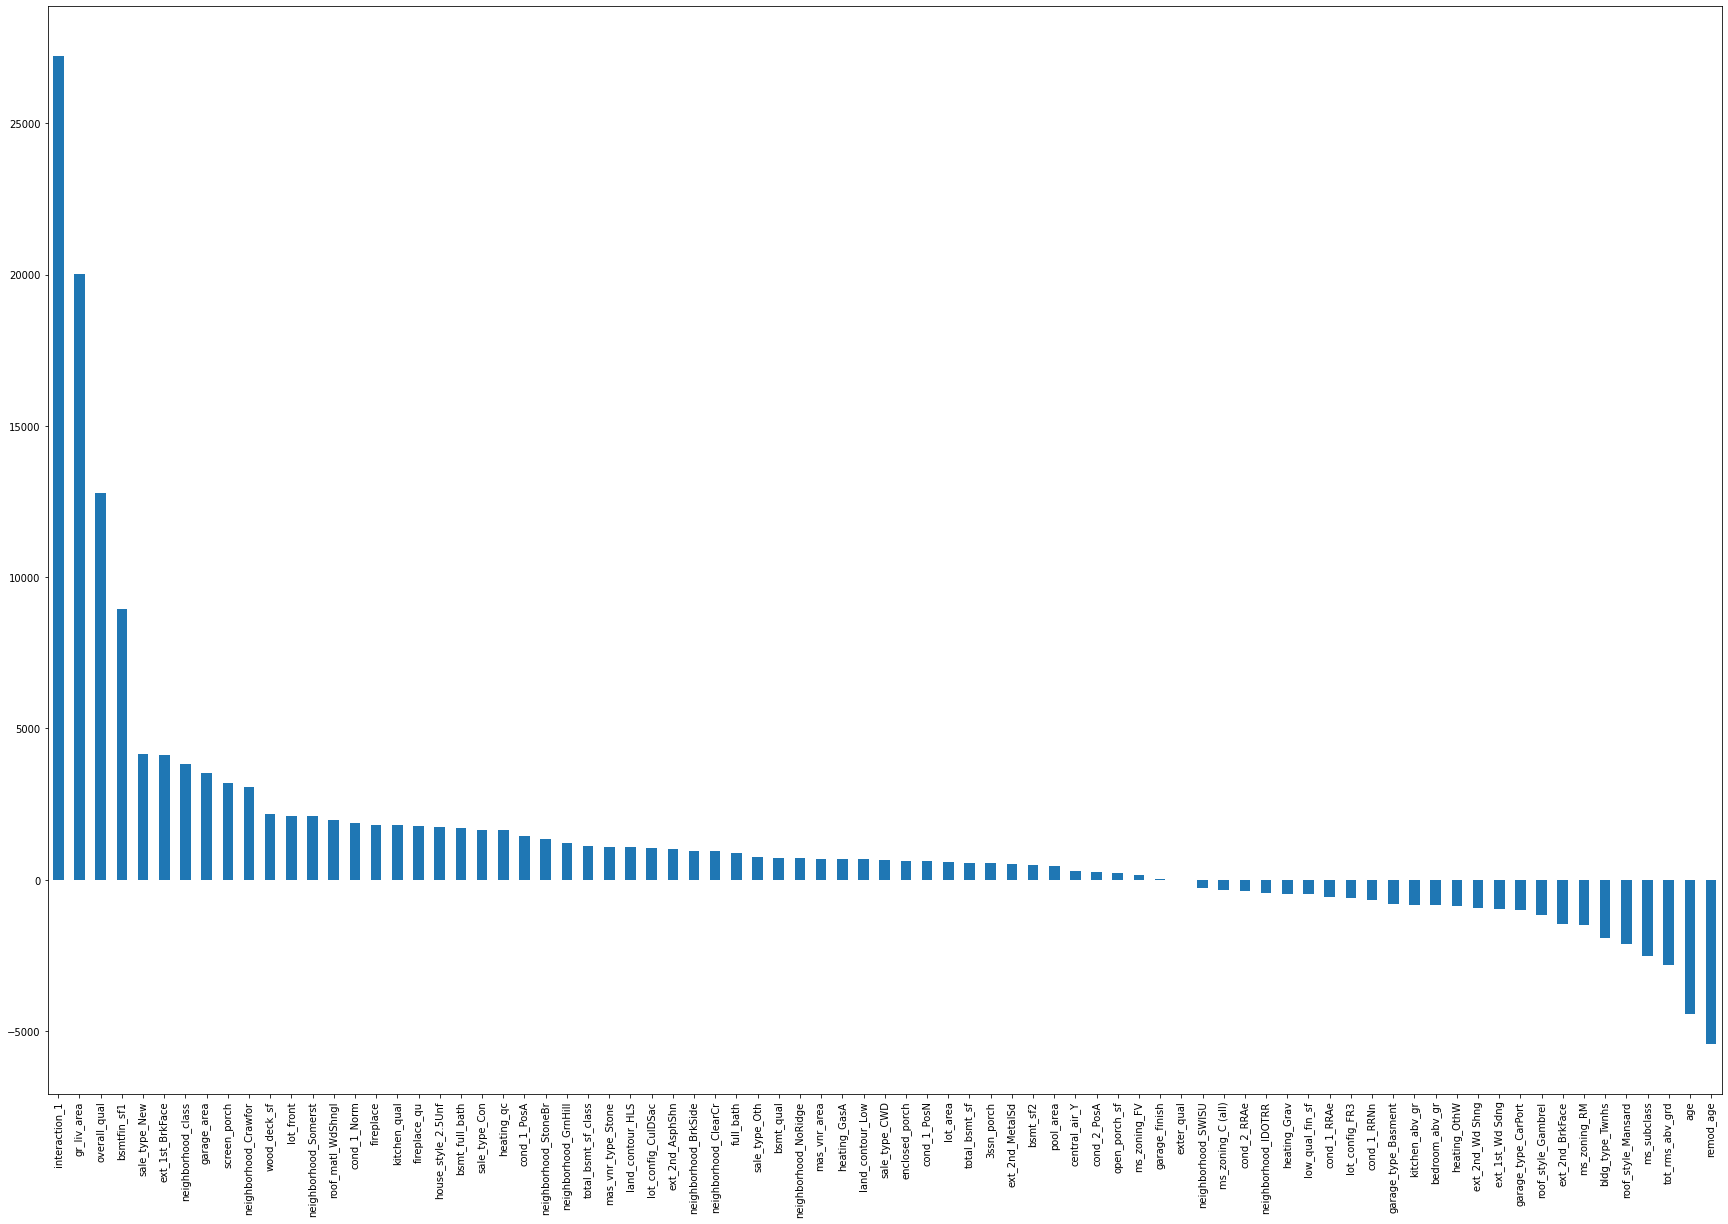

In [31]:
plt.figure(figsize=(30,20))
pd.Series(lasso_best.coef_, index = refined).sort_values(ascending = False).plot.bar()

**Hypothesis not all ordinal category should be ranked**

In [32]:
df = pd.read_csv('temp.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [33]:
df

,index,id,pid,ms_subclass,ms_zoning,lot_front,lot_area,street,alley,lot_shape,...,screen_porch,pool_area,misc_val,mo_sold,sale_type,sale_price,gr_liv_area_class,sale_price_classified,total_bsmt_sf_class,neighborhood_class
0,0,109,533352170,60,RL,69.0552,13517,Pave,NoAlley,IR1,...,0,0,0,3,WD,130500.0,0,0,0,0
1,1,544,531379050,60,RL,43.0000,11492,Pave,NoAlley,IR1,...,0,0,0,4,WD,220000.0,0,0,0,0
2,2,153,535304180,20,RL,68.0000,7922,Pave,NoAlley,Reg,...,0,0,0,1,WD,109000.0,0,0,0,0
3,3,318,916386060,60,RL,73.0000,9802,Pave,NoAlley,Reg,...,0,0,0,4,WD,174000.0,0,0,0,0
4,4,255,906425045,50,RL,82.0000,14235,Pave,NoAlley,IR1,...,0,0,0,3,WD,138500.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,873,1662,527377110,60,RL,80.0000,8000,Pave,NoAlley,Reg,...,0,0,0,11,WD,NaN,0,0,0,0
2925,874,1234,535126140,60,RL,90.0000,14670,Pave,NoAlley,Reg,...,0,0,0,8,WD,NaN,0,0,0,0
2926,875,1373,904100040,20,RL,55.0000,8250,Pave,NoAlley,Reg,...,0,0,0,8,WD,NaN,0,0,0,0
2927,876,1672,527425140,20,RL,60.0000,9000,Pave,NoAlley,Reg,...,0,0,0,5,WD,NaN,0,0,0,0


In [34]:
# defining a function to return rate
def rate_Po_Excellent(col): 
    rate_dict = {'NoBsmt': 0,'NoFireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
                 'Gtl':3, 'Sev':1, 'Mod':2,
                'IR1':3, 'Reg':4, 'IR2':2, 'IR3':1,
                'AllPub':3, 'NoSeWa':1, 'NoSewr':2,
                'No':1, 'Gd':4, 'Av':3, 'Mn':2,
                'NoGarage':0, 'Unf': 1, 'RFn': 2, 'Fin': 3,
                'SBrkr':5, 'FuseF':3,'FuseA':4, 'FuseP':2, 'Mix':1,
                'Typ':8, 'Mod':5, 'Min2':6, 'Maj1':4, 'Min1':7, 'Sev':2, 'Sal':1, 'Maj2':3,
                'Y':3, 'N':1, 'P':2,
                 'Unf':1 , 'Rec':3 , 'NoBsmt':0 , 'BLQ':4 , 'GLQ':6 , 'LwQ':2 , 'ALQ':5 ,
                }

    return rate_dict[col]

In [35]:
main_variables = ['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
 'exter_qual', 'bsmt_qual', 'heating_qc', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area',
 'kitchen_qual', 'garage_finish', 'fireplace_qu', 'total_bsmt_sf_class', 'neighborhood_class', 'gr_liv_area_class',
    'sale_price','garage_area','bsmtfin_sf1','tot_rms_abv_grd' ]
other_columns = [col for col in df.columns if (col not in main_variables) & (col not in ['index','id','pid','sale_price_classified'])]


In [36]:
for cat in main_variables:
    if df[cat].dtype == 'O':
        df[cat] = df[cat].map(rate_Po_Excellent)
        print(cat,df[cat].unique())

exter_qual [4 3 5 2]
bsmt_qual [3 4 2 0 5 1]
heating_qc [5 3 4 2 1]
kitchen_qual [4 3 2 5 1]
garage_finish [2 1 3 0]
fireplace_qu [0 3 4 1 5 2]


In [37]:
# Change other columns to get dummies for cat features

other_df = df.copy()[other_columns]

other_cat_features = [col for col in other_df.columns if df[col].dtype == 'O']
other_numerical_features = [col for col in other_df.columns if df[col].dtype != 'O']


other_cat = pd.get_dummies(data = other_df[other_cat_features], drop_first = True)
other_num = other_df[other_numerical_features]

other_df = pd.concat([other_num,other_cat], axis = 1)
other_df

,ms_subclass,overall_cond,mas_vnr_area,bsmt_sf2,bsmt_unf_sf,2nd_flr_sf,low_qual_fin_sf,bsmt_full_bath,bsmt_half_bath,full_bath,...,paved_drive_Y,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,60,8,289.0,0.0,192.0,754,0,0.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
1,60,5,132.0,0.0,276.0,1209,0,1.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
2,20,7,0.0,0.0,326.0,0,0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,1
3,60,5,0.0,0.0,384.0,700,0,0.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
4,50,8,0.0,0.0,676.0,614,0,0.0,0.0,2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,60,6,0.0,153.0,0.0,793,0,1.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
2925,60,7,410.0,0.0,529.0,884,0,0.0,0.0,2,...,1,0,0,0,0,0,0,0,0,1
2926,20,5,0.0,492.0,210.0,0,0,0.0,0.0,1,...,1,0,0,0,0,0,0,0,0,1
2927,20,6,0.0,0.0,248.0,0,0,0.0,0.0,1,...,1,0,0,0,0,0,0,0,0,1


In [38]:
id_adder = df['id']

df_main = df[main_variables]
df_main = pd.concat([id_adder,df_main], axis = 1)

df_main_refined = pd.concat([df_main,other_df], axis = 1)

In [39]:
df_main_refined

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,paved_drive_Y,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
0,109,69.0552,13517,6,34,5,4,3,5,725.0,...,1,0,0,0,0,0,0,0,0,1
1,544,43.0000,11492,7,13,12,4,4,5,913.0,...,1,0,0,0,0,0,0,0,0,1
2,153,68.0000,7922,5,57,3,3,3,3,1057.0,...,1,0,0,0,0,0,0,0,0,1
3,318,73.0000,9802,5,4,3,3,4,4,384.0,...,1,0,0,0,0,0,0,0,0,1
4,255,82.0000,14235,6,110,17,3,2,3,676.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,1662,80.0000,8000,6,33,33,3,3,3,1084.0,...,1,0,0,0,0,0,0,0,0,1
2925,1234,90.0000,14670,6,42,9,4,3,5,1104.0,...,1,0,0,0,0,0,0,0,0,1
2926,1373,55.0000,8250,5,40,40,3,3,5,952.0,...,1,0,0,0,0,0,0,0,0,1
2927,1672,60.0000,9000,4,36,36,3,3,3,864.0,...,1,0,0,0,0,0,0,0,0,1


In [40]:
df_main_refined['interaction_1'] = df_main_refined['lot_area']**0.5 *\
df_main_refined['overall_qual']*df_main_refined['kitchen_qual']*\
df_main_refined['exter_qual']* df_main_refined['bsmt_qual']* df_main_refined['heating_qc']*\
df_main_refined['total_bsmt_sf']**0.5 * df_main_refined['1st_flr_sf']**0.5 *df_main_refined['gr_liv_area']**0.5\
* df_main_refined['tot_rms_abv_grd']

In [41]:
df_main_refined.to_csv('main_refined.csv')